In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from cesium import featurize
import sqlite3
from astropy.stats import sigma_clip as sc
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as GridSpec

# AAM efforts

Here I am going to attempt to improve the uncertainty measurements and create a nice looking plot for our Zooniverse effort.

In [5]:
def strateva(mag, a = 0.027665,
             b = 1.285193044293278e-09,
             c = 1.0999892234090642e-19):
    return a + b*10**(0.4*mag) + c*10**(0.8*mag)

In [6]:
def lc_breaks(time, break_width=45):
    breaks = np.where(np.diff(time[np.argsort(time)]) > break_width)
    return breaks

In [7]:
def aam_plot(time, mag, mag_unc, 
             period=1, ptf_filt=2,
             ):
    """Plot a light curve suitable for Zooniverse classification
    """

    color_dict = {1: "LightSeaGreen",
                  2: "Crimson"}

    model_unc = strateva(mag)
    mean_mag = np.mean(mag)
    
    obs_breaks = lc_breaks(time)[0] + 1
    seasons = len(obs_breaks) + 1
    season_dict = {}
    total_obs_duration = 0
    for season_num in range(seasons):
        if season_num == 0:
            season = time[np.argsort(time)][0:obs_breaks[season_num]]
        elif season_num == seasons - 1:
            season = time[np.argsort(time)][obs_breaks[season_num-1]:]
        else:
            season = time[np.argsort(time)][obs_breaks[season_num-1]:obs_breaks[season_num]]

        season_dict["start{:d}".format(season_num)] = min(season)
        season_dict["end{:d}".format(season_num)] = max(season)
        season_dict["length{:d}".format(season_num)] = np.round(np.ptp(season)) + 2
        total_obs_duration += season_dict["length{:d}".format(season_num)]
    

    
    ###### FIGURE #######    
    plot_gap = np.round(0.01*total_obs_duration/(1 - 0.01*len(obs_breaks))).astype(int)

    fig = plt.figure()

    gs = GridSpec.GridSpec(4, int(total_obs_duration) + len(obs_breaks)*plot_gap)


    amplitude = np.ptp(mean_mag - mag)
    ymin = min(mean_mag - mag) - 0.05*amplitude
    ymax = max(mean_mag - mag) + 0.05*amplitude
    if amplitude > 0.5:
        ymajor = np.round(amplitude)/4
        yminor = np.round(amplitude)/20
    else:
        ymajor = 0.1
        yminor = 0.02
        
    for season_num in range(seasons):
        obs_length = season_dict["length{:d}".format(season_num)]
        obs_start = season_dict["start{:d}".format(season_num)]
        obs_end = season_dict["end{:d}".format(season_num)]

        if season_num == 0:
            ax_start = 0
            ax_end = int(obs_length)
        else:
            ax_start = ax_end + plot_gap
            ax_end = ax_start + int(obs_length)
        ax = plt.subplot(gs[0, ax_start:ax_end])

        obs_this_season = np.logical_and(time >= obs_start,
                                         time <= obs_end)

        ax.errorbar(time[obs_this_season] - 54900.5, 
                     mean_mag - mag[obs_this_season], 
                     yerr=model_unc[obs_this_season], 
                     fmt="o", ms=4, mfc=color_dict[ptf_filt], 
                     ecolor=color_dict[ptf_filt], elinewidth=0.5,
                     mec="0.2", mew=0.2)
        ax.xaxis.set_major_locator(MultipleLocator(50))
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(obs_start - 1 - 54900.5, obs_end + 1 - 54900.5)

        if season_num == 0:
            ax.yaxis.set_major_locator(MultipleLocator(ymajor))
            ax.yaxis.set_minor_locator(MultipleLocator(yminor))
            ax.set_ylabel(r"$\Delta \, \mathrm{mag}$")

        else:
            ax.set_yticks([])
            ax.set_yticks([], minor=True)

    ax_phase = plt.subplot(gs[1:, :])
    for repeat in [-1, 0, 1]:
        ax_phase.errorbar((time/period) % 1 + repeat, 
                          mean_mag - mag, 
                          yerr=model_unc, 
                          fmt="o", ms=9, mfc=color_dict[ptf_filt], 
                          ecolor=color_dict[ptf_filt], elinewidth=0.5,
                          mec="0.2", mew=0.4, alpha=0.95)
    ax_phase.set_xlabel("Phase")
    ax_phase.set_ylabel(r"$\Delta \, \mathrm{mag}$")
    
    ax_phase.axvline(x=0, ls='--', color='0.8', lw=1)
    ax_phase.axvline(x=1, ls='--', color='0.8', lw=1)
    ax_phase.set_xlim(-0.2,1.2)
    ax_phase.set_ylim(ymin,ymax)
    ax_phase.yaxis.set_major_locator(MultipleLocator(ymajor))
    ax_phase.yaxis.set_minor_locator(MultipleLocator(yminor))

    ax_phase.text(0.5, 0.74*amplitude, "Time (d)", va="bottom", ha="center")
#     ax_phase.text(-0.2, 0.5, r"$\Delta \, \mathrm{mag}$", 
#                   rotation=90, va="bottom", ha="center")
    fig.subplots_adjust(hspace=0.6, top=0.98,right=0.98)
    fig.show()
    
    return(fig)

In [427]:
filename = "./test_lcs/27882110006813.ipac_tbl"
ipac_lc = Table.read(filename, format='ipac')

hjd = np.array(ipac_lc["obsmjd"])
mag = np.array(ipac_lc["mag_autocorr"])
mag_unc = np.array(ipac_lc["magerr_auto"])

clipped_obs = sc(mag, sigma=5).mask
cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                           mag[~clipped_obs], 
                                           mag_unc[~clipped_obs], 
                                           features_to_use=["freq1_freq", 
                                                            "amplitude", 
                                                            "freq1_amplitude1"])
period = 1/float(cs_feats["freq1_freq"][0])

/Users/adamamiller/miniconda3/envs/NUREU17/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


<IPython.core.display.Javascript object>


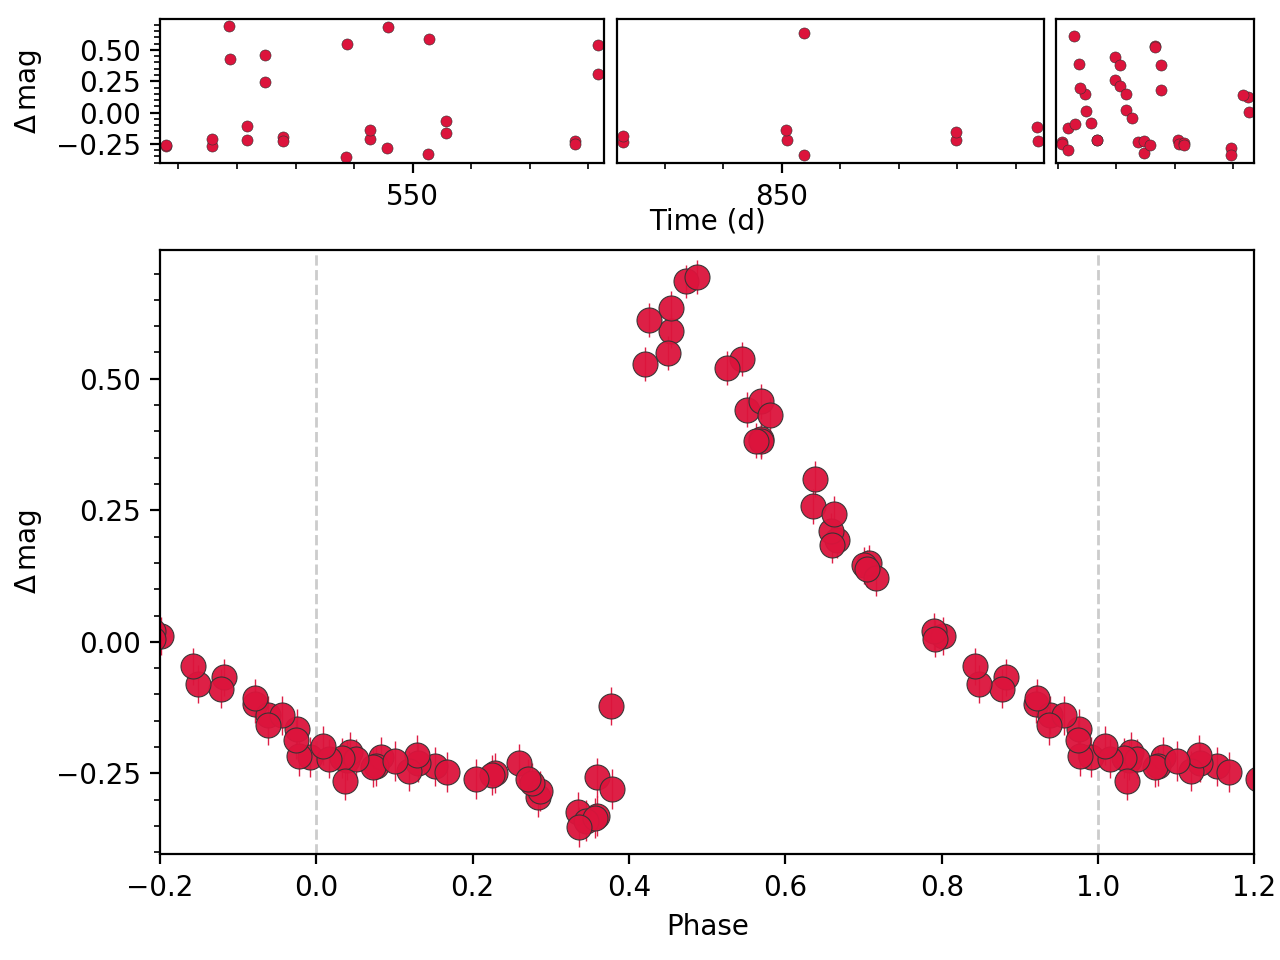

In [428]:
aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=period)

In [429]:
filename = "./test_lcs/35632000005467.ipac_tbl"

ipac_lc = Table.read(filename, format='ipac')

hjd = np.array(ipac_lc["obsmjd"])
mag = np.array(ipac_lc["mag_autocorr"])
mag_unc = np.array(ipac_lc["magerr_auto"])

clipped_obs = sc(mag, sigma=5).mask
cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                           mag[~clipped_obs], 
                                           mag_unc[~clipped_obs], 
                                           features_to_use=["freq1_freq", 
                                                            "amplitude", 
                                                            "freq1_amplitude1"])
period = 1/float(cs_feats["freq1_freq"][0])

/Users/adamamiller/miniconda3/envs/NUREU17/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


<IPython.core.display.Javascript object>


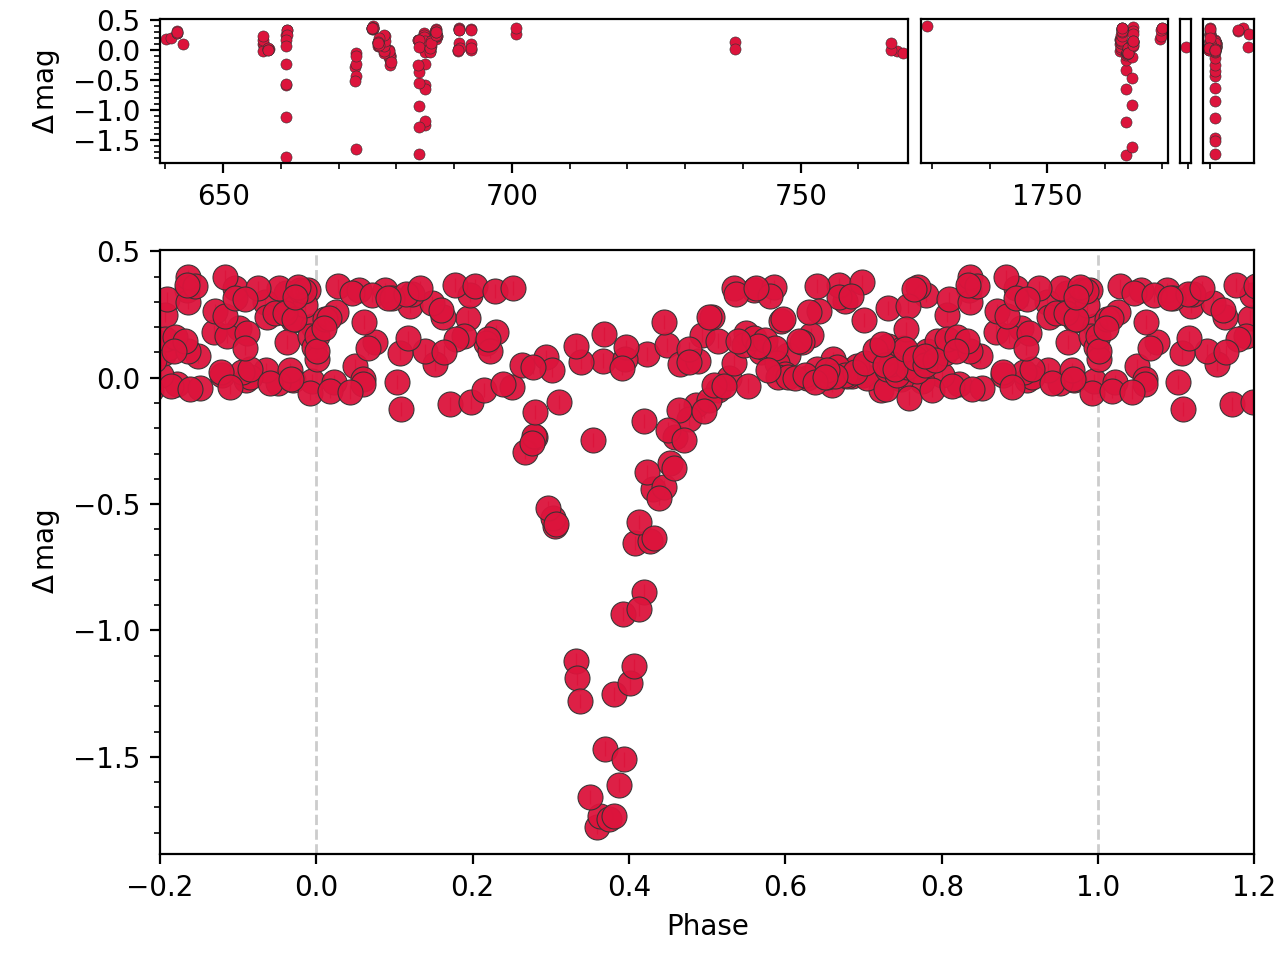

In [430]:
aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=period)

In [61]:
ipac_lc= Table.read("./scripts/ptf_query/byOid/curves_oid{:_>17}.tbl".format(objs[0][i]), format = 'ipac')
clipped = sc(ipac_lc['obsmjd'], sigma = 5).mask
plt.plot(ipac_lc['obsmjd'][~clipped], ipac_lc['mag_autocorr'][~clipped])

34782080006069 0.9661765236066832


<IPython.core.display.Javascript object>


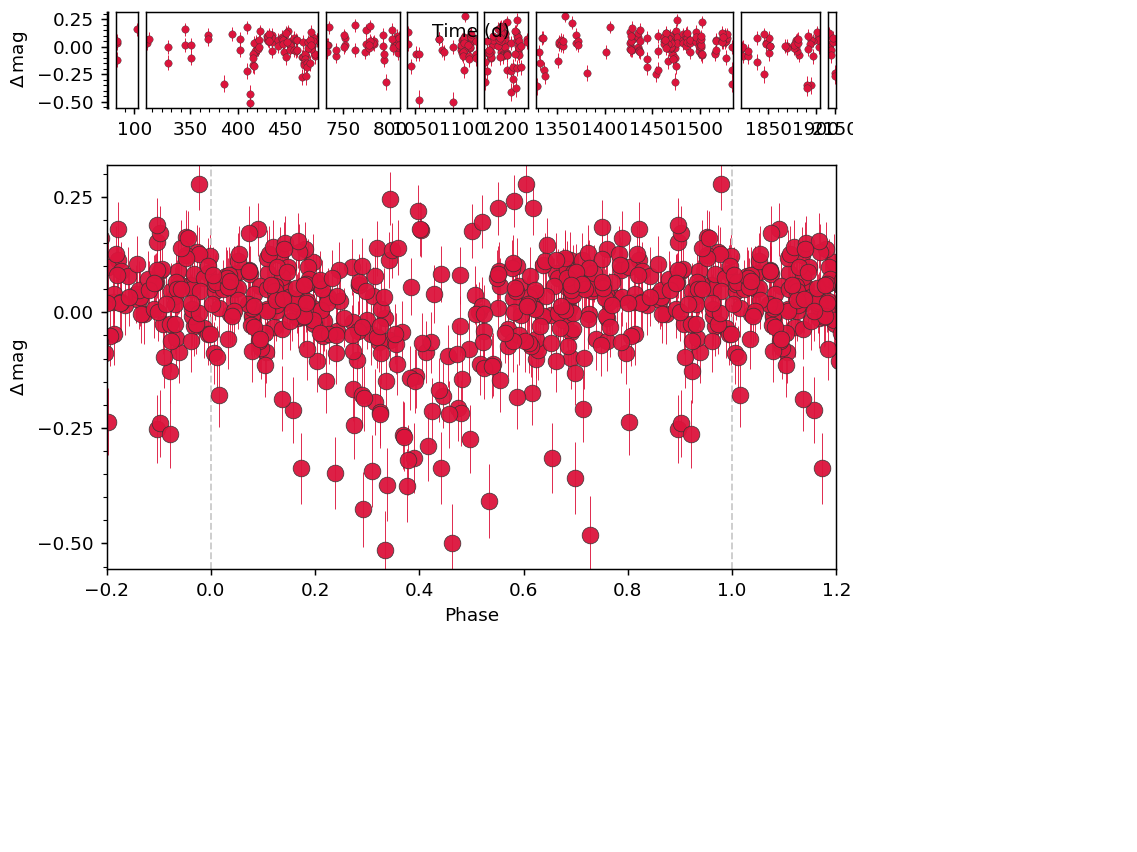

1000372000005342 11.871319116455313


<IPython.core.display.Javascript object>


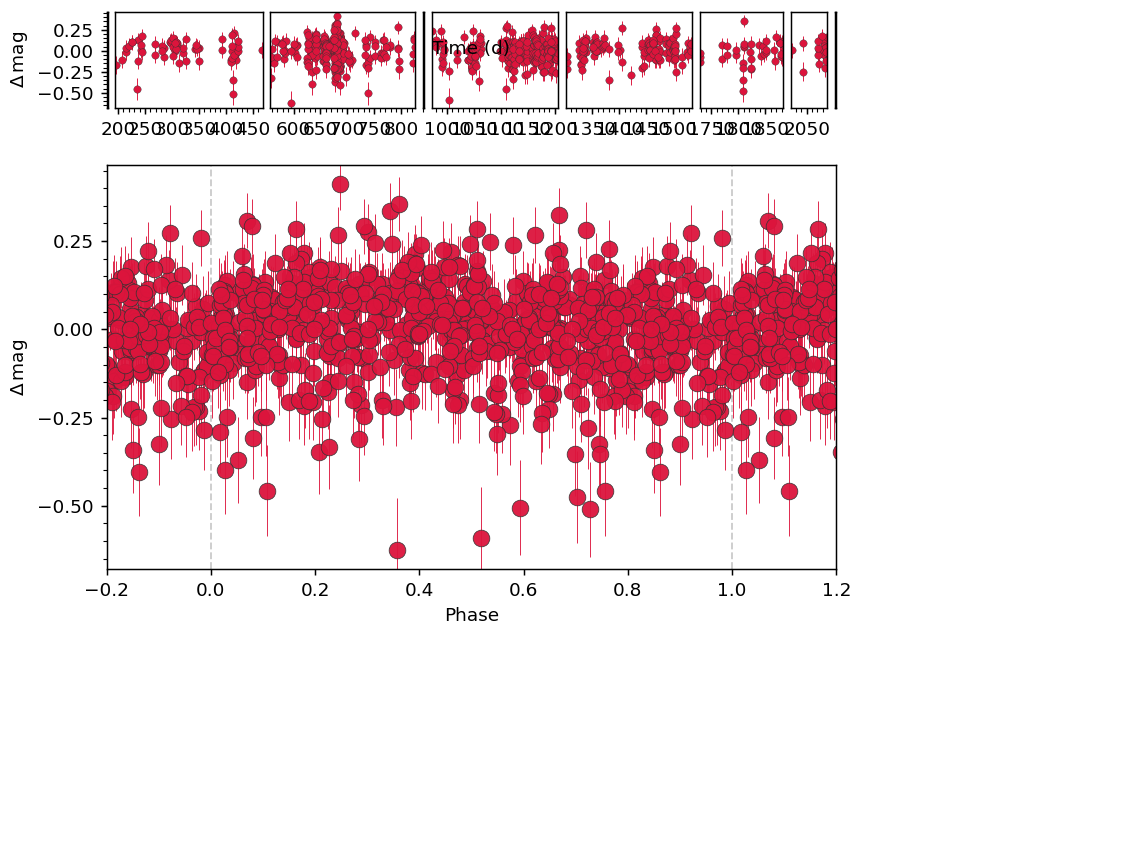

1000132090002622 24.27521520220893


<IPython.core.display.Javascript object>


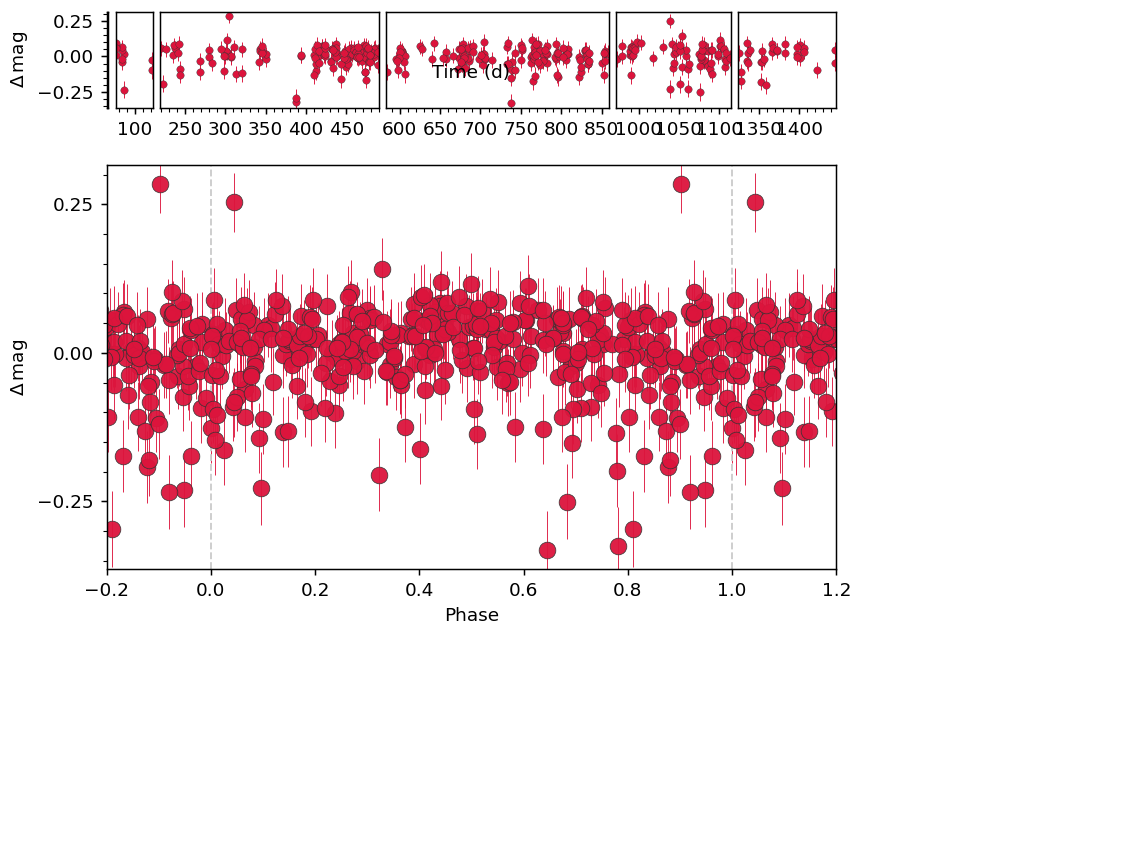

1000032070004250 4.400255352714128


<IPython.core.display.Javascript object>


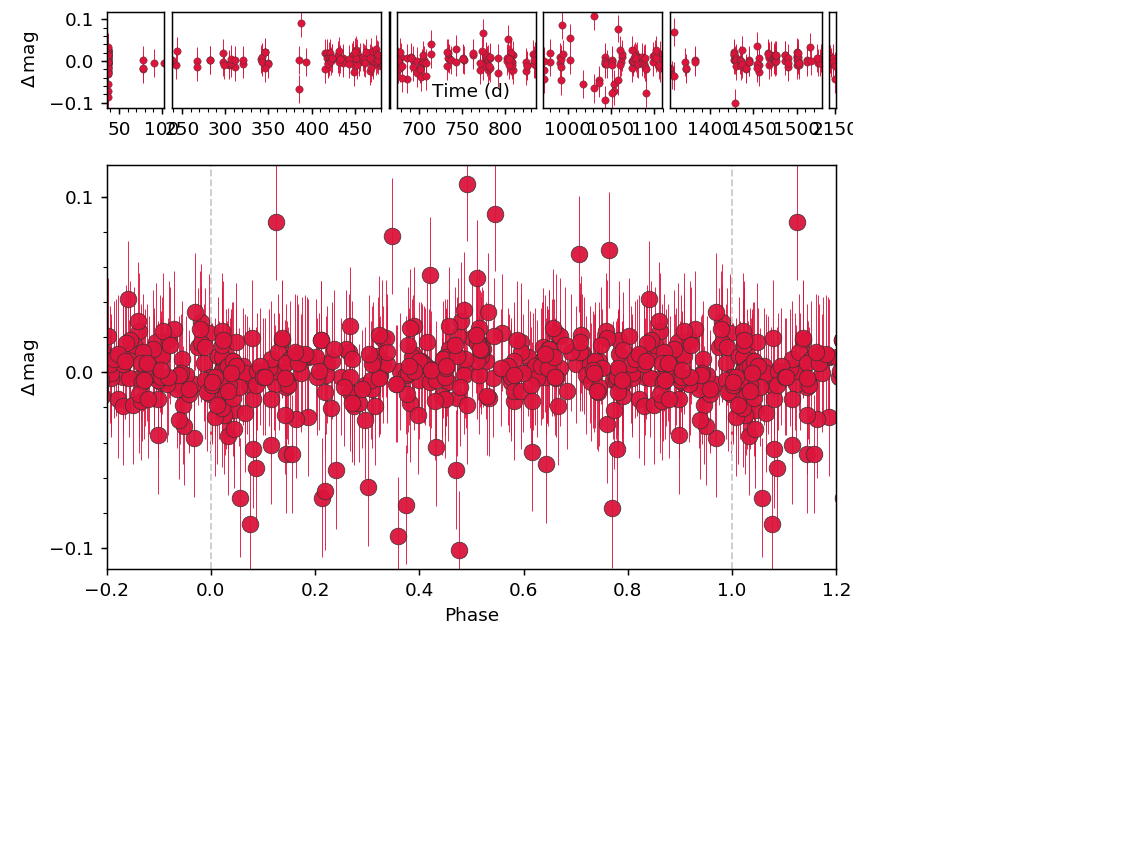

32752090006076 24.021384244382727


<IPython.core.display.Javascript object>


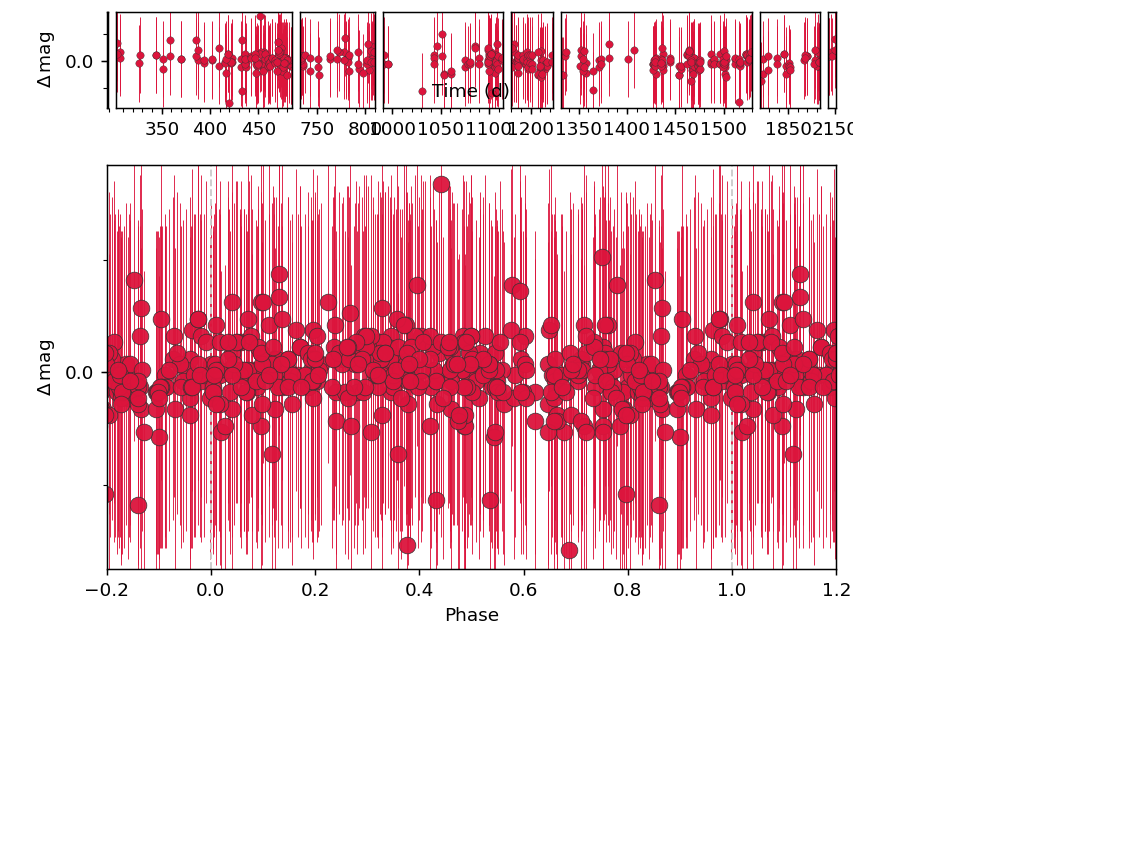

1000262000009395 1.9658126230205066


<IPython.core.display.Javascript object>


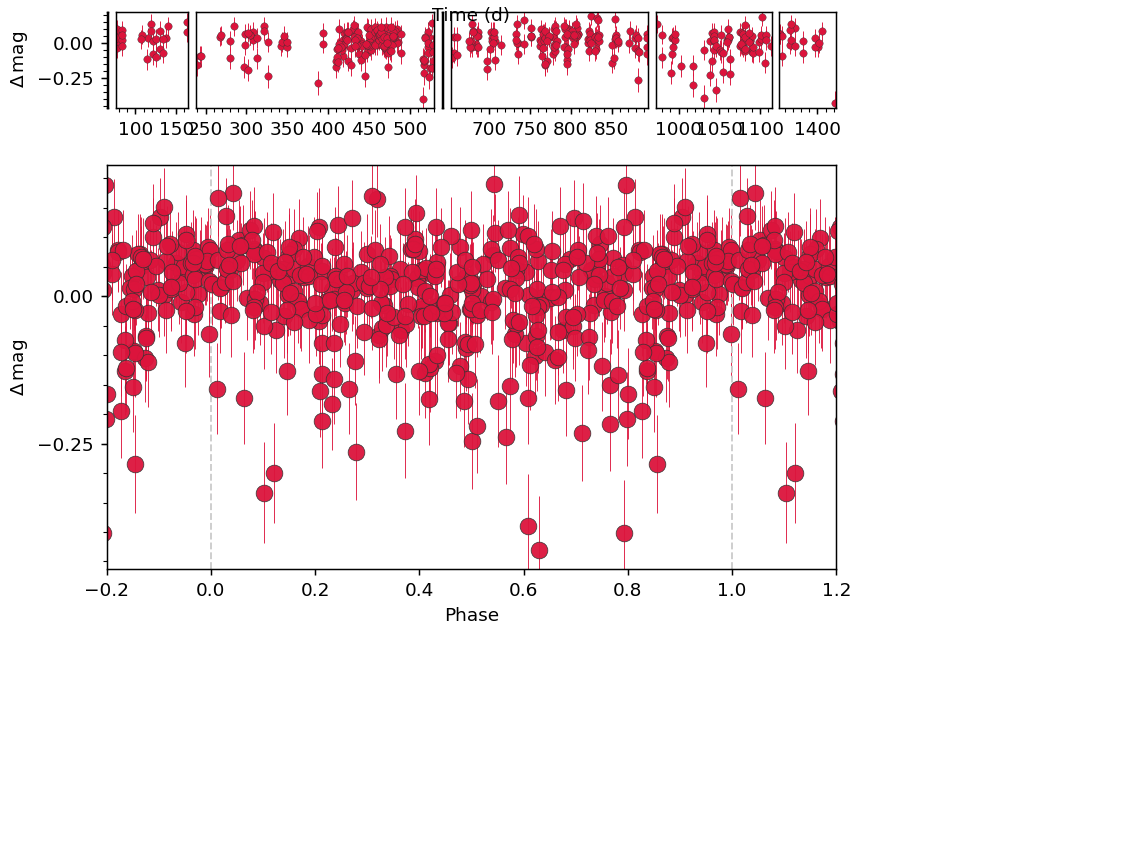

1010032020000304 0.38416332286911337


<IPython.core.display.Javascript object>


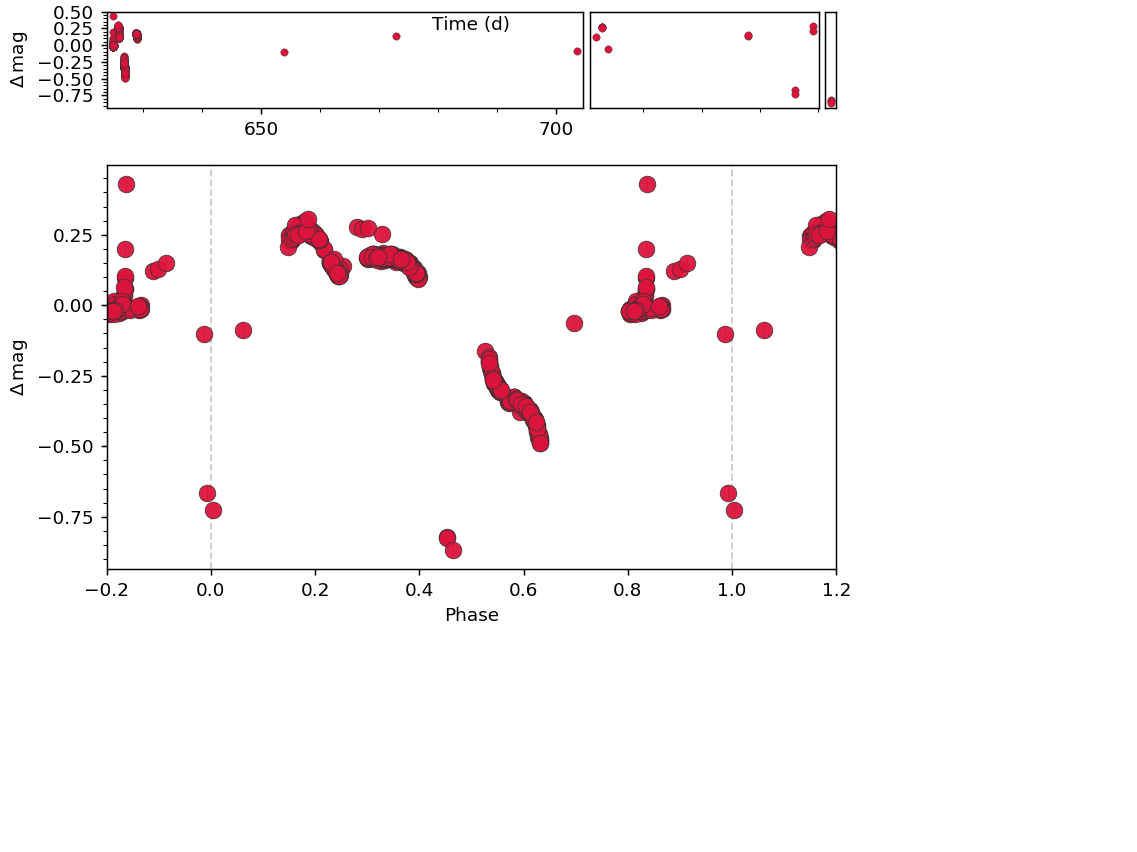

1000132080001307 3.0117800572087194


<IPython.core.display.Javascript object>

35782020008941 1.9690603954603985


<IPython.core.display.Javascript object>

1000132100001989 0.003253813740855427


<IPython.core.display.Javascript object>

32752090002674 16.015600410878744


<IPython.core.display.Javascript object>

1000492020020166 0.002604486676546221


<IPython.core.display.Javascript object>

1000202110005003 1.8955454870119322


<IPython.core.display.Javascript object>

32752090005468 1.971512226760738


<IPython.core.display.Javascript object>

32752090011033 30.076324762291318


<IPython.core.display.Javascript object>

33772070008542 32.63849199581568


<IPython.core.display.Javascript object>

1000132100006277 2.005895131189005


<IPython.core.display.Javascript object>

35782020009056 24.673474133282376


<IPython.core.display.Javascript object>

1010032020000784 1.9970529044490497


<IPython.core.display.Javascript object>

1000132100006871 18.11943192861744


<IPython.core.display.Javascript object>

1000132050007544 18.62374524807618


/home/nick/miniconda3/envs/NUREU17/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

34782080004323 15.219716040732752


<IPython.core.display.Javascript object>

33762090007117 31.593979082531142


<IPython.core.display.Javascript object>

45882060022602 1.005467732988779


<IPython.core.display.Javascript object>

34782080008026 21.754068010410545


<IPython.core.display.Javascript object>

34782080004755 15.43359357098705


<IPython.core.display.Javascript object>

34782080006451 2.005585214930195


<IPython.core.display.Javascript object>

1010032020000679 0.22555841368943136


<IPython.core.display.Javascript object>

1010032020002146 0.13159184408977104


<IPython.core.display.Javascript object>

34782080007299 21.383039289259752


<IPython.core.display.Javascript object>

1010032020001407 1.0322796328376316


<IPython.core.display.Javascript object>

1000132050009130 26.426501840142908


<IPython.core.display.Javascript object>

34782080004825 2.052780735226003


<IPython.core.display.Javascript object>

1010032020002092 0.22842930770775235


<IPython.core.display.Javascript object>

1000202110006664 0.9661046439169649


<IPython.core.display.Javascript object>

33762090005806 11.65789675150178


<IPython.core.display.Javascript object>

1000372000006169 17.015359560224486


<IPython.core.display.Javascript object>

1010032020000574 0.30870392122003565


<IPython.core.display.Javascript object>

1000032070008117 1.000852117342646


<IPython.core.display.Javascript object>

1000132080002470 1.1331336826594391


<IPython.core.display.Javascript object>

1000202110007760 0.0028737154134237997


<IPython.core.display.Javascript object>

1000202110000549 23.90487721585789


<IPython.core.display.Javascript object>

34782080010490 28.605482094266122


<IPython.core.display.Javascript object>

1000032070001284 1.7097519680007798


<IPython.core.display.Javascript object>

1000052000004388 3.406163629632919


<IPython.core.display.Javascript object>

1000132090003340 0.9656596113138717


<IPython.core.display.Javascript object>

1000372000002051 9.120718624382224


<IPython.core.display.Javascript object>

33772070004862 0.03388628601652648


<IPython.core.display.Javascript object>

1010032020002375 0.7084207037708821


<IPython.core.display.Javascript object>

1000202110000639 1.4322154613092226


<IPython.core.display.Javascript object>

1000202110007542 3.994442817776274


<IPython.core.display.Javascript object>

1000132085000452 0.9690524769239944


<IPython.core.display.Javascript object>

32752090009776 0.0026610365944581666


<IPython.core.display.Javascript object>

1000132050002522 22.525930044951295


<IPython.core.display.Javascript object>

1000372000005382 0.0006927521489803573


<IPython.core.display.Javascript object>

33772070006155 25.105276670962382


<IPython.core.display.Javascript object>

1000202110006592 4.311978671715528


<IPython.core.display.Javascript object>

33772070002797 32.956822705159205


<IPython.core.display.Javascript object>

1000372000001210 2.886585970379952


<IPython.core.display.Javascript object>

34782080004470 32.12034435292235


<IPython.core.display.Javascript object>

33772070004994 24.822745506187697


<IPython.core.display.Javascript object>

1010032020000134 1.5048177463531969


<IPython.core.display.Javascript object>

1000132040001583 29.01536954216198


<IPython.core.display.Javascript object>

1000132080004381 16.824302818261568


<IPython.core.display.Javascript object>

1000132040002125 13.048596884786138


<IPython.core.display.Javascript object>

1010032020002121 0.20286730904462502


<IPython.core.display.Javascript object>

35782020001906 1.18007257301947


<IPython.core.display.Javascript object>

1000132040006494 29.492929281973684


<IPython.core.display.Javascript object>

1000202110000059 0.001190261798980998


<IPython.core.display.Javascript object>

1000052000008476 1.715308661790568


<IPython.core.display.Javascript object>

34782080005342 0.514873384311802


<IPython.core.display.Javascript object>

33772070002898 25.515012309840348


<IPython.core.display.Javascript object>

1000132050002560 26.22548845793006


<IPython.core.display.Javascript object>

1000132100004003 2.0059507554733855


<IPython.core.display.Javascript object>

1000202110000540 0.9661517647462046


<IPython.core.display.Javascript object>

1010032020001489 0.240023302781741


<IPython.core.display.Javascript object>

1000202110001015 32.706532967957344


<IPython.core.display.Javascript object>

35782020005691 30.865783209698627


<IPython.core.display.Javascript object>

32752090007747 18.80131468385784


<IPython.core.display.Javascript object>

1000132100004036 31.974448940918382


<IPython.core.display.Javascript object>

1000202110007496 0.9680963841988973


<IPython.core.display.Javascript object>

33762090006514 2.6165572151200247


<IPython.core.display.Javascript object>

1000132100005955 2.0089935968004715


<IPython.core.display.Javascript object>

1000132100002015 12.985748156763181


<IPython.core.display.Javascript object>

1000372000001667 0.02143787055628403


<IPython.core.display.Javascript object>

1000372000004570 0.000655306086873311


<IPython.core.display.Javascript object>

1000262000002112 1.0027871141641447


<IPython.core.display.Javascript object>

1010032020000998 0.23014080221867447


<IPython.core.display.Javascript object>

33762090002997 0.03377432515388629


<IPython.core.display.Javascript object>

32752090007732 23.056972544629144


<IPython.core.display.Javascript object>

33772070008684 22.509316812886663


<IPython.core.display.Javascript object>

33772070002992 32.46065885325726


<IPython.core.display.Javascript object>

1000132050008653 14.994880805432919


<IPython.core.display.Javascript object>

32752090010588 29.657394644480124


<IPython.core.display.Javascript object>

34782080004959 20.008216775897743


<IPython.core.display.Javascript object>

1000132050006003 4.05455783521825


<IPython.core.display.Javascript object>

1000132050002872 24.956667961239564


<IPython.core.display.Javascript object>

32752090001828 24.49905402060318


<IPython.core.display.Javascript object>

35782020006475 23.490700312759742


<IPython.core.display.Javascript object>

33772070007018 25.166671301252702


<IPython.core.display.Javascript object>

In [8]:
conn = sqlite3.connect('features.db')
cur = conn.cursor()

cur.execute("""select oid, freq1_freq from sigfeatscopy""")
fet = cur.fetchall()
objs = list(zip(*fet))


for i in np.random.randint(0,18848,100):
    print(objs[0][i], objs[1][i])
    ipac_lc = Table.read("./scripts/ptf_query/byOid/curves_oid{:_>17}.tbl".format(objs[0][i]), format = 'ipac')
    hjd = np.array(ipac_lc["obsmjd"])
    mag = np.array(ipac_lc["mag_autocorr"])
    mag_unc = np.array(ipac_lc["magerr_auto"])
    
    clipped_obs = sc(mag, sigma=5).mask
    
    fig = aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], period = 1/objs[1][i])
    fig.savefig("./scripts/ptf_query/New_Data_Files/figs_v02_{:_>17}".format(objs[0][i]))

In [14]:
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table'""")
cur.fetchall()

[('lightcurves',),
 ('feats2',),
 ('lc_new',),
 ('sigfeats',),
 ('sig1feats',),
 ('sigfeatscopy',)]